# B5S1 Análisis Discriminante Lineal

- [Carga de los Datos](#Carga-de-los-datos)
- [Los datos de Default](#Figura-4.1---Los-datos-de-Default)
- [4.4 Análisis Discriminante Lineal](#4.4-Análisis-Discriminante-Lineal)
- [Lab: 4.6.3 Análisis Discriminante Lineal](#4.6.3-Análisis-Discriminante-Lineal)
- [Lab: 4.6.4 Análisis Discriminante Cuadrático](#4.6.4-Análisis-Discriminante-Cuadrático)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

import pandas.util.testing as tm

<ipython-input-1-1b63b7e0000d>:21: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Carga de los Datos

In [4]:
# Datos basados en el libro 'ISLR' en formato separado por comas
#df = pd.read_excel('C:/Users/jgeis/Documents/Claudia/Cursos/Impartidos/PythonParaCS/Data/Default.xlsx')
#También se pueden bajar los datos de:
filename='https://raw.githubusercontent.com/jasonm/islr-exercises/master/Data/Default.csv'
df=pd.read_csv(filename)
# Para una descripción de estos datos vea: https://rdrr.io/cran/ISLR/man/Default.html
# Nota: factorize() regresa dos objectos: un arreglo de etiqueta y un arreglo con los valores únicos.
# Solo estamos interesados en el primer objeto. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


###  Figure 4.1 - El conjunto de datos de Default

In [5]:
# Tomamos una fracciónd de las muestras donde el valor objetivo es no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Tomamos todas las muestras donde el valor objetivo es 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

C:\Users\jgeis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jgeis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='default', ylabel='income'>

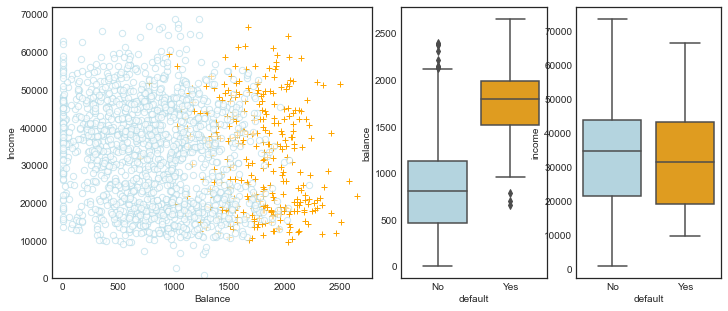

In [6]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
#gs.tight_layout(plt.gcf())

## 4.4 Análisis Discriminante Lineal
### Table 4.4 


In [7]:
X = df[['balance', 'income', 'student2']]
y = df.default2

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [11]:
#Cálculo automático de la matriz de confusión:
#Tomado de: http://stephacking.com/linear-discriminant-analysis-lda-python-3x3-confusion-matrix-regression-model-lda/
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
cm.T

array([[9645,  254],
       [  22,   79]], dtype=int64)

In [13]:
cm.sum()

10000

In [14]:
sum(cm)

array([9899,  101], dtype=int64)

In [19]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



In [19]:
(9645+79)/10000

0.9724

### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [23]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,9435,140
True,232,193


#  Lab

### 4.6.3 Linear Discriminant Analysis

In [25]:
df = pd.read_csv('C:/Users/jgeis/Documents/Claudia/Cursos/Impartidos/PythonParaCS/Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [26]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [27]:
lda.priors_

array([0.49198397, 0.50801603])

In [28]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [29]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [30]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]], dtype=int64)

In [31]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [32]:
pred_p = lda.predict_proba(X_test)

In [33]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182], dtype=int64))

In [34]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False]), array([252], dtype=int64))

### 4.6.4 Quadratic Discriminant Analysis

In [35]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [36]:
qda.priors_

array([0.49198397, 0.50801603])

In [37]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [38]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]], dtype=int64)

In [39]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252

